# CM3720 - Machine Learning Assignment
### *215533M - Kodithuwakku A.S.*

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# to handle outdated sklearn library
!pip uninstall xgboost scikit-learn -y
!pip install xgboost==1.7.6 scikit-learn==1.1.3

Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 37.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.


# Import Libraries and Load the Dataset

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats

import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, f1_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import xgboost as xgb

In [ ]:
SDDataset = pd.read_csv('/content/drive/MyDrive/L3S1/Machine Learning/Assignment/jm1.csv')

# Initial Exploratory Data Analysis

In [ ]:
SDDataset.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1,1,1,1,1,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17,36,112,86,13,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,129,29,28,2,17,135,329,271,5,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,...,28,1,6,0,11,16,76,50,7,True


In [ ]:
SDDataset.shape

(10885, 22)

In [ ]:
# Checking the sum of missing values
SDDataset.isnull().sum()

,0
loc,0
v(g),0
ev(g),0
iv(g),0
n,0
v,0
l,0
d,0
i,0
e,0


There are no any missing values in the dataset. So no need to handle missing data.

In [ ]:
SDDataset.dtypes

,0
loc,float64
v(g),float64
ev(g),float64
iv(g),float64
n,float64
v,float64
l,float64
d,float64
i,float64
e,float64


In [ ]:
SDDataset.describe()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment
count,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,1.088500e+04,10885.000000,1.088500e+04,10885.000000,10885.000000,10885.00000,10885.000000
mean,42.016178,6.348590,3.401047,4.001599,114.389738,673.758017,0.135335,14.177237,29.439544,3.683637e+04,0.224766,2.046465e+03,26.252274,2.737529,4.62554,0.370785
std,76.593332,13.019695,6.771869,9.116889,249.502091,1938.856196,0.160538,18.709900,34.418313,4.343678e+05,0.646408,2.413154e+04,59.611201,9.008608,9.96813,1.907969
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,11.000000,2.000000,1.000000,1.000000,14.000000,48.430000,0.030000,3.000000,11.860000,1.619400e+02,0.020000,9.000000e+00,4.000000,0.000000,0.00000,0.000000
50%,23.000000,3.000000,1.000000,2.000000,49.000000,217.130000,0.080000,9.090000,21.930000,2.031020e+03,0.070000,1.128300e+02,13.000000,0.000000,2.00000,0.000000
75%,46.000000,7.000000,3.000000,4.000000,119.000000,621.480000,0.160000,18.900000,36.780000,1.141643e+04,0.210000,6.342500e+02,28.000000,2.000000,5.00000,0.000000
max,3442.000000,470.000000,165.000000,402.000000,8441.000000,80843.080000,1.300000,418.200000,569.780000,3.107978e+07,26.950000,1.726655e+06,2824.000000,344.000000,447.00000,108.000000


# Data Cleaning

In [ ]:
# Convert object columns (index 16 to 21) to float
def convert_object_to_float(df, start_idx, end_idx):
    for col in df.columns[start_idx:end_idx + 1]:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except Exception as e:
            print(f"Error converting column {col} to float: {e}")
    return df

dataset = convert_object_to_float(SDDataset, start_idx=16, end_idx=21)

Let's check whether any missing values are available after the conversion.

In [ ]:
SDDataset.isnull().sum()

,0
loc,0
v(g),0
ev(g),0
iv(g),0
n,0
v,0
l,0
d,0
i,0
e,0


We can see that there some missing values. So we need to remove them.

In [ ]:
SDDataset.dropna(axis=0,inplace=True)

In [ ]:
SDDataset.isnull().sum()

,0
loc,0
v(g),0
ev(g),0
iv(g),0
n,0
v,0
l,0
d,0
i,0
e,0


Now all the missing values have been removed.

# Data Visualization

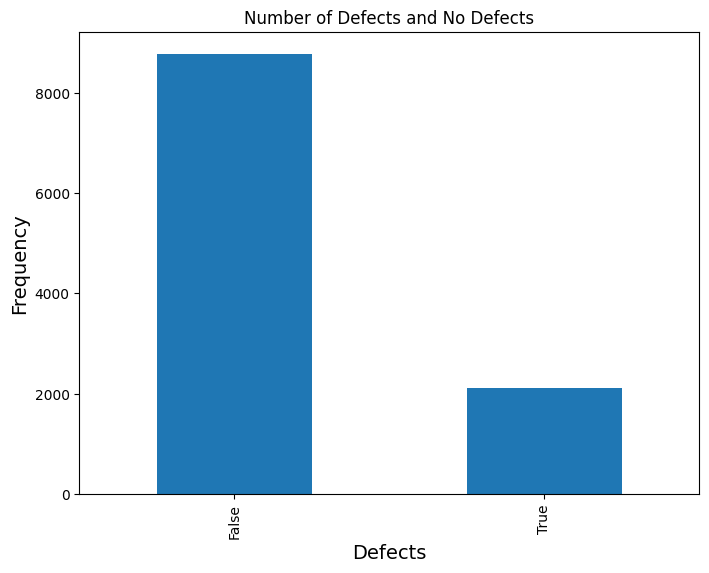

In [ ]:
ax = SDDataset['defects'].value_counts().plot(kind='bar', title='Number of Defects and No Defects',figsize=(8, 6))
ax.set_xlabel("Defects",fontsize=14)
ax.set_ylabel("Frequency",fontsize=14)
plt.show()

We can see that the dataset is imbalanced.

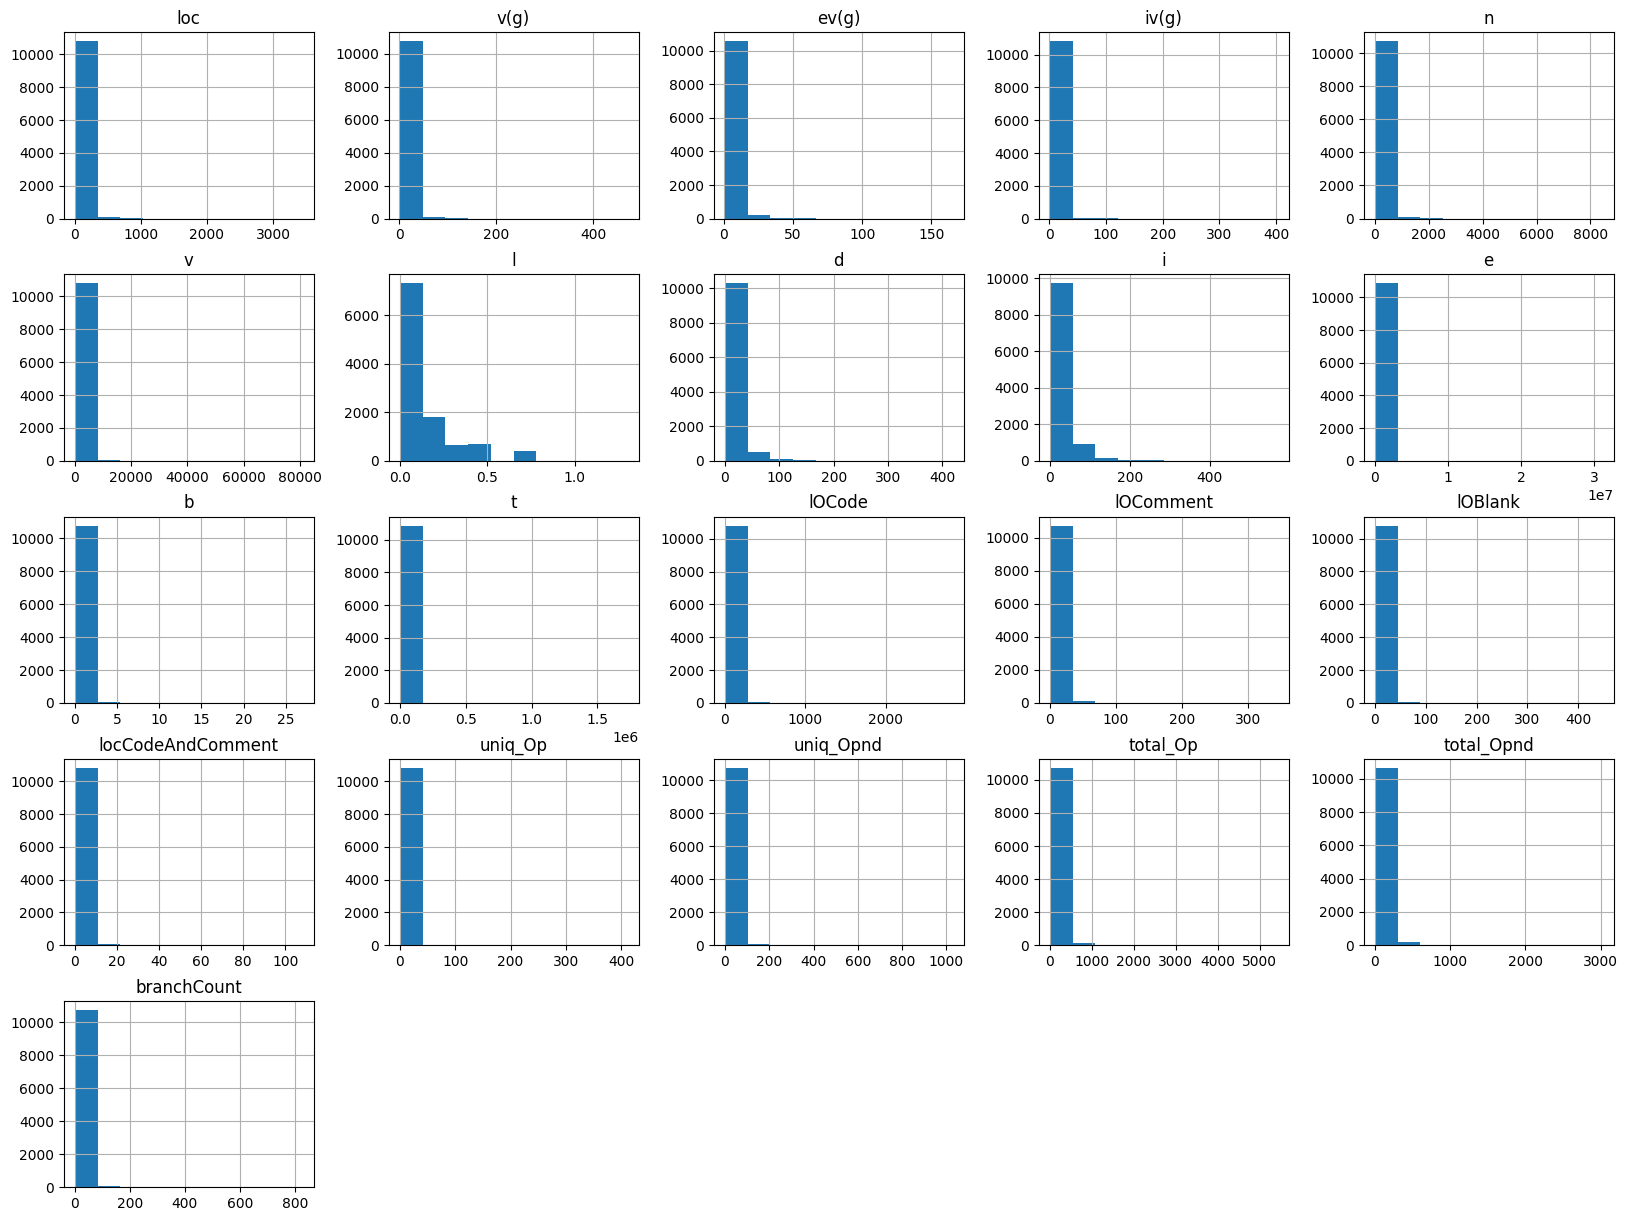

In [ ]:
SDDataset.iloc[:,:-1].hist(figsize=(20, 15))
plt.show()

We can see that all the variables are positively skewed, ao that we have to normalize them.

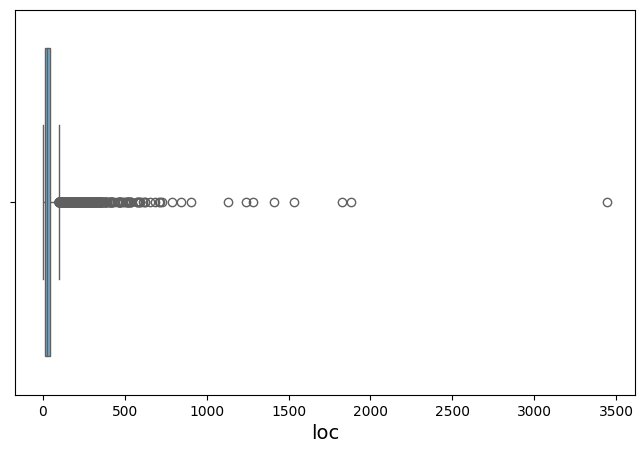

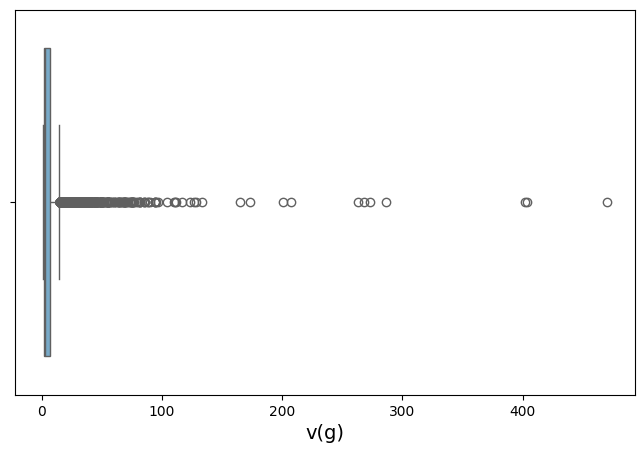

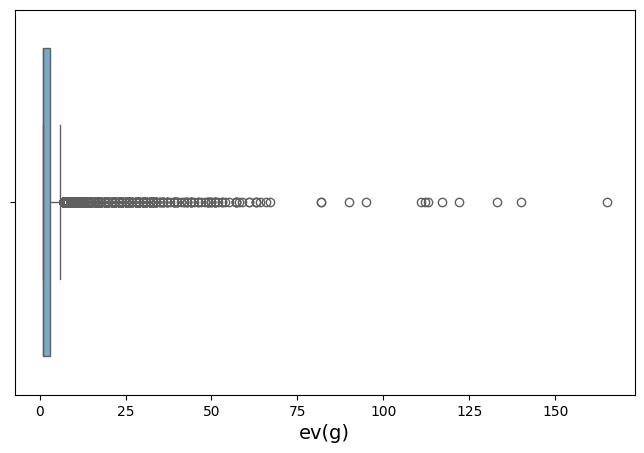

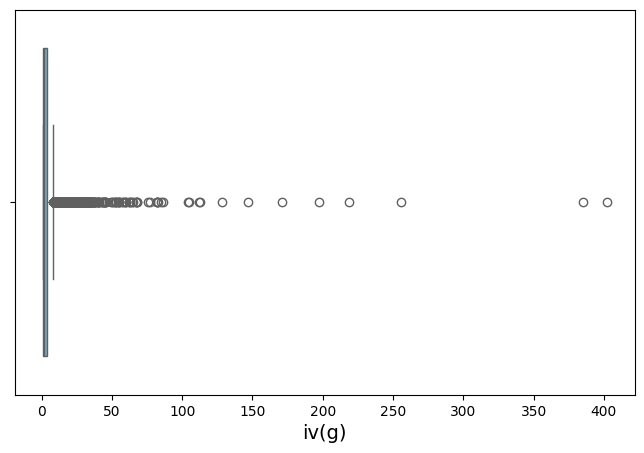

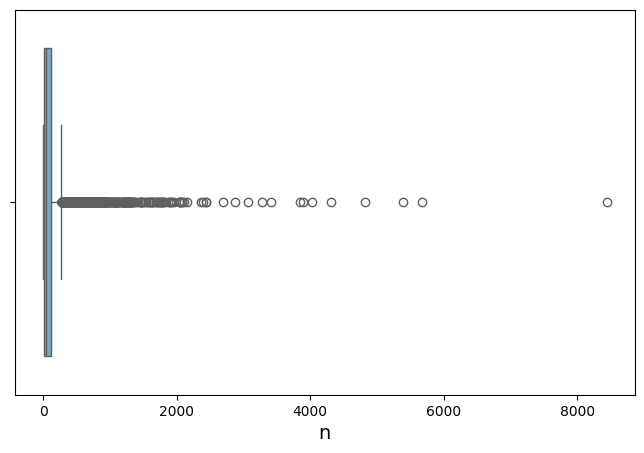

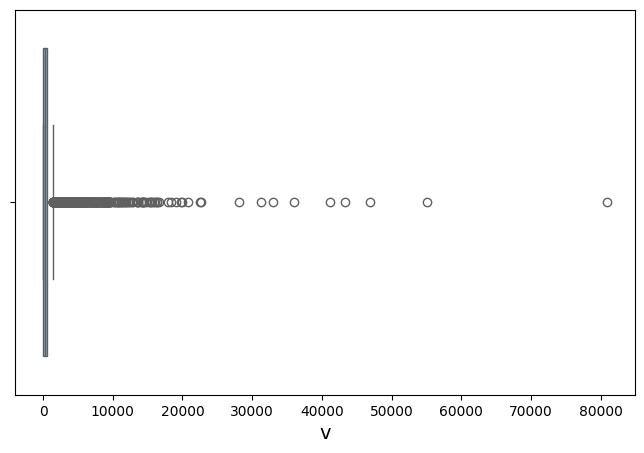

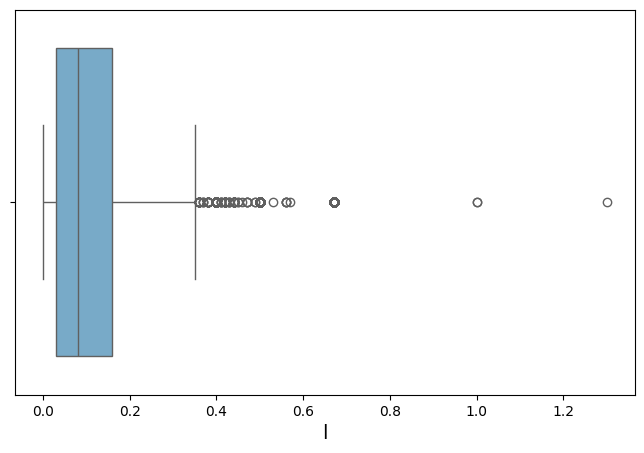

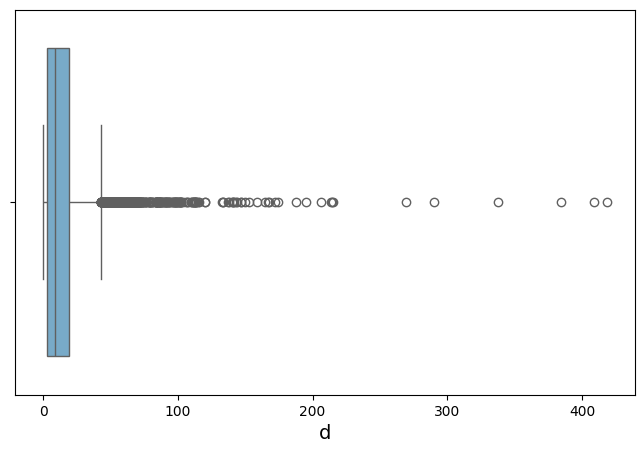

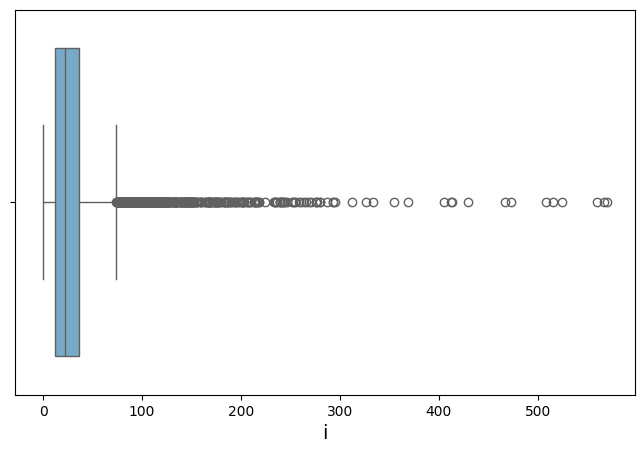

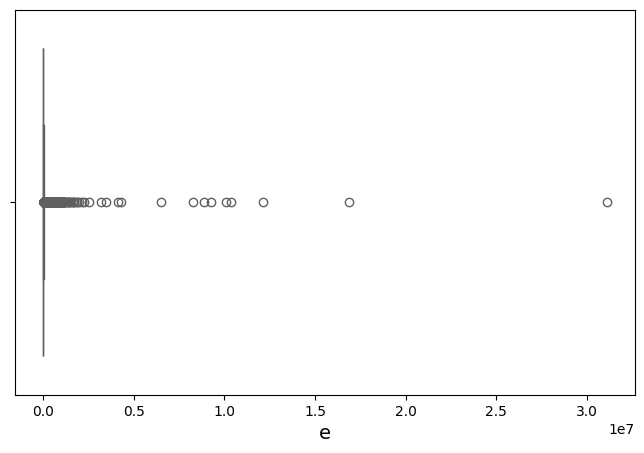

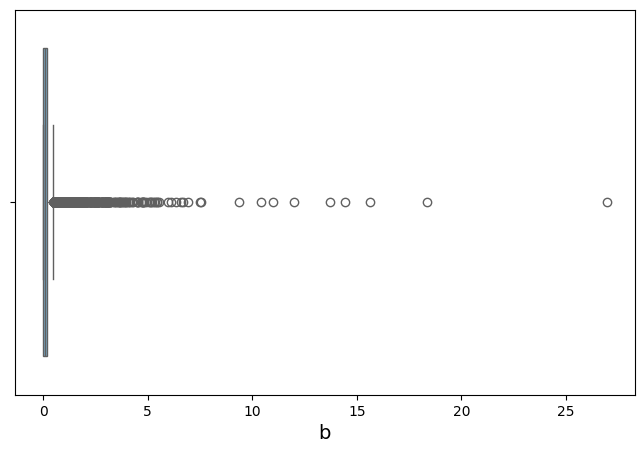

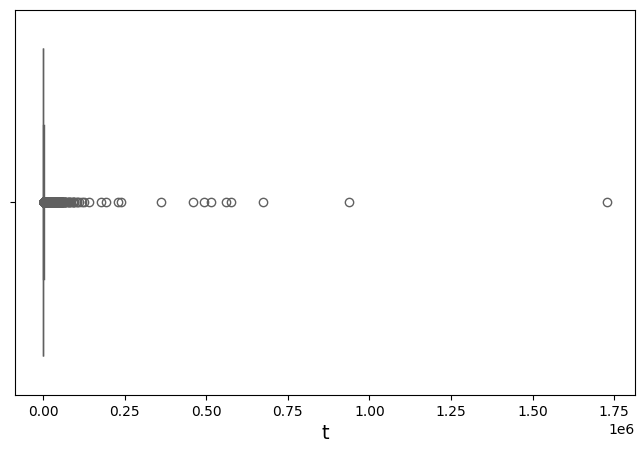

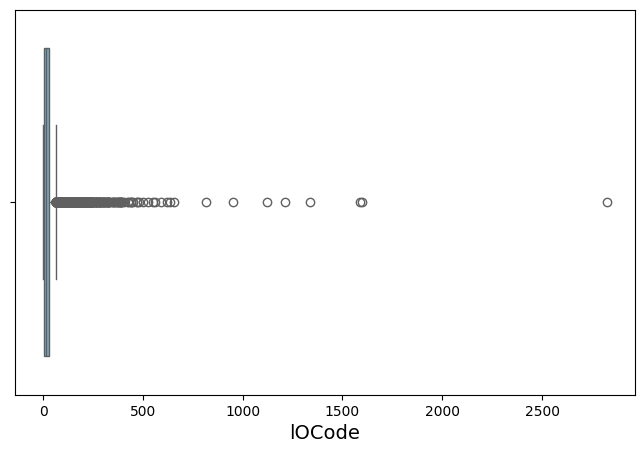

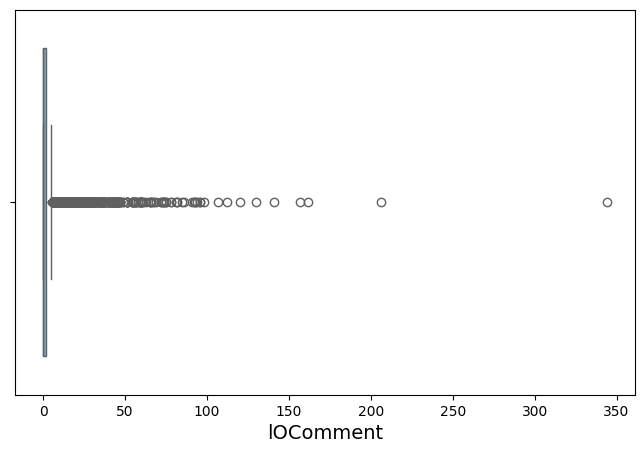

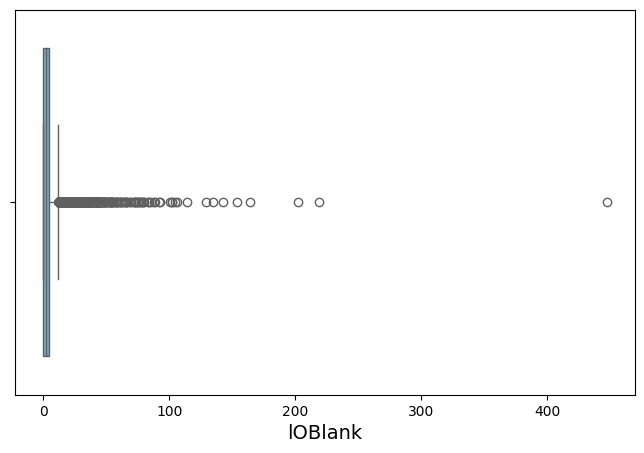

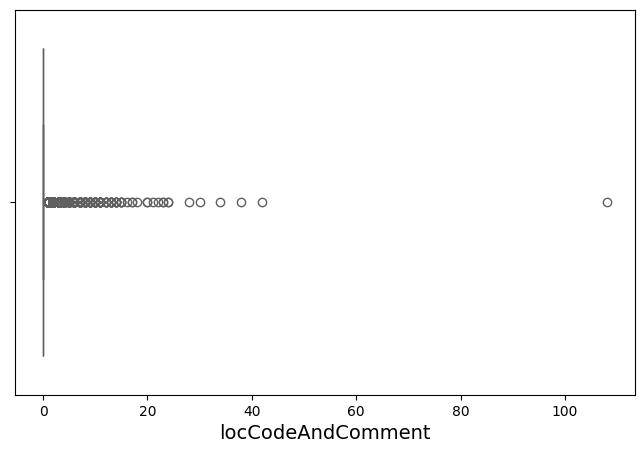

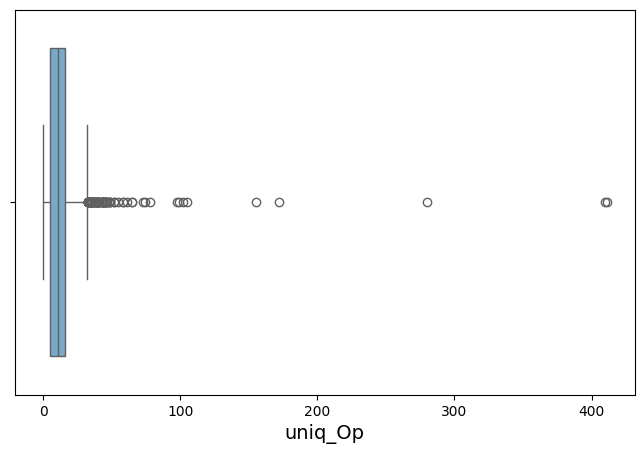

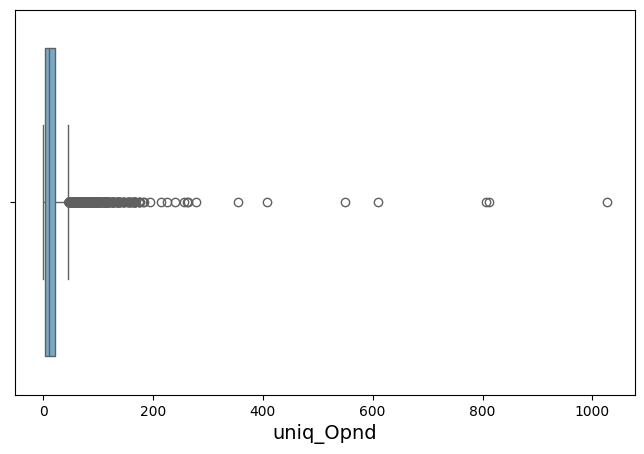

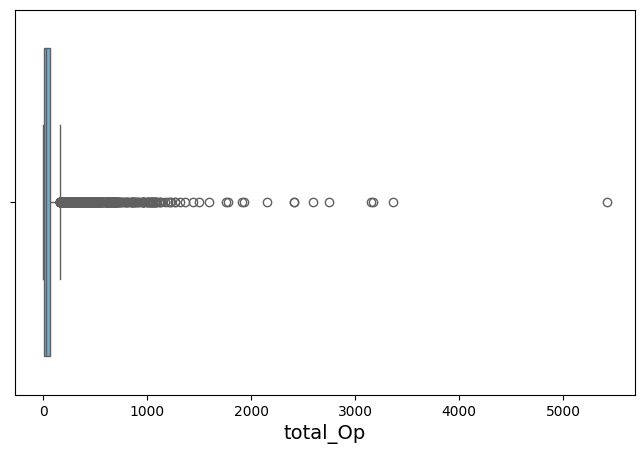

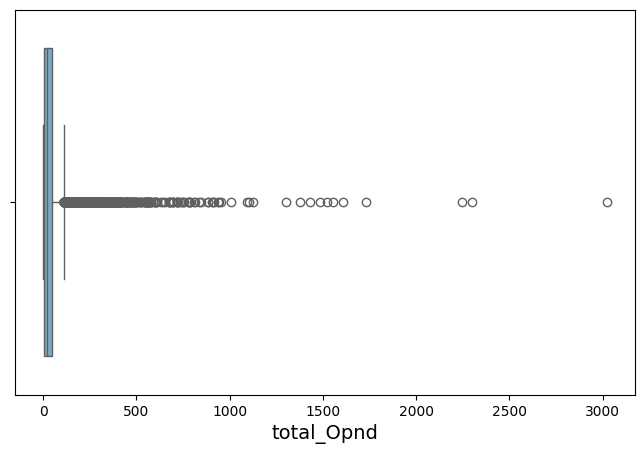

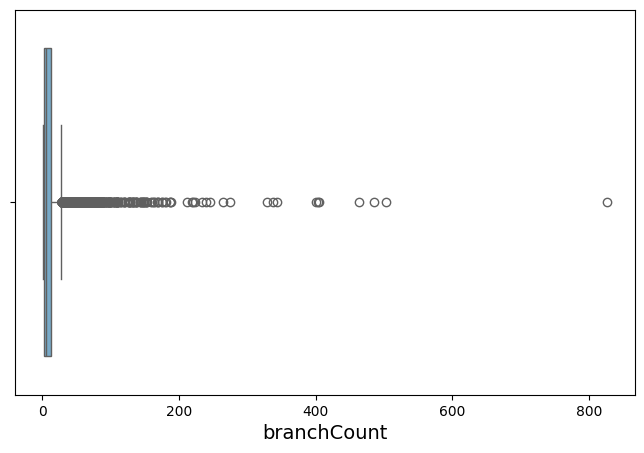

In [ ]:
# Plotting box and whisker to ensure of if there are many outliers
for i in SDDataset.iloc[:,:-1]:
    plt.figure(figsize=(8,5))
    ax = sns.boxplot(x=SDDataset[i], palette="Blues")
    ax.set_xlabel(i,fontsize=14)
    plt.show()

We can see that, the dataset contains huge number of outliers. Eventhough there are many outliers, I cannot remove them because most outliers are from the minority class.

# Data Preprocessing

## Draw Q-Q Plots

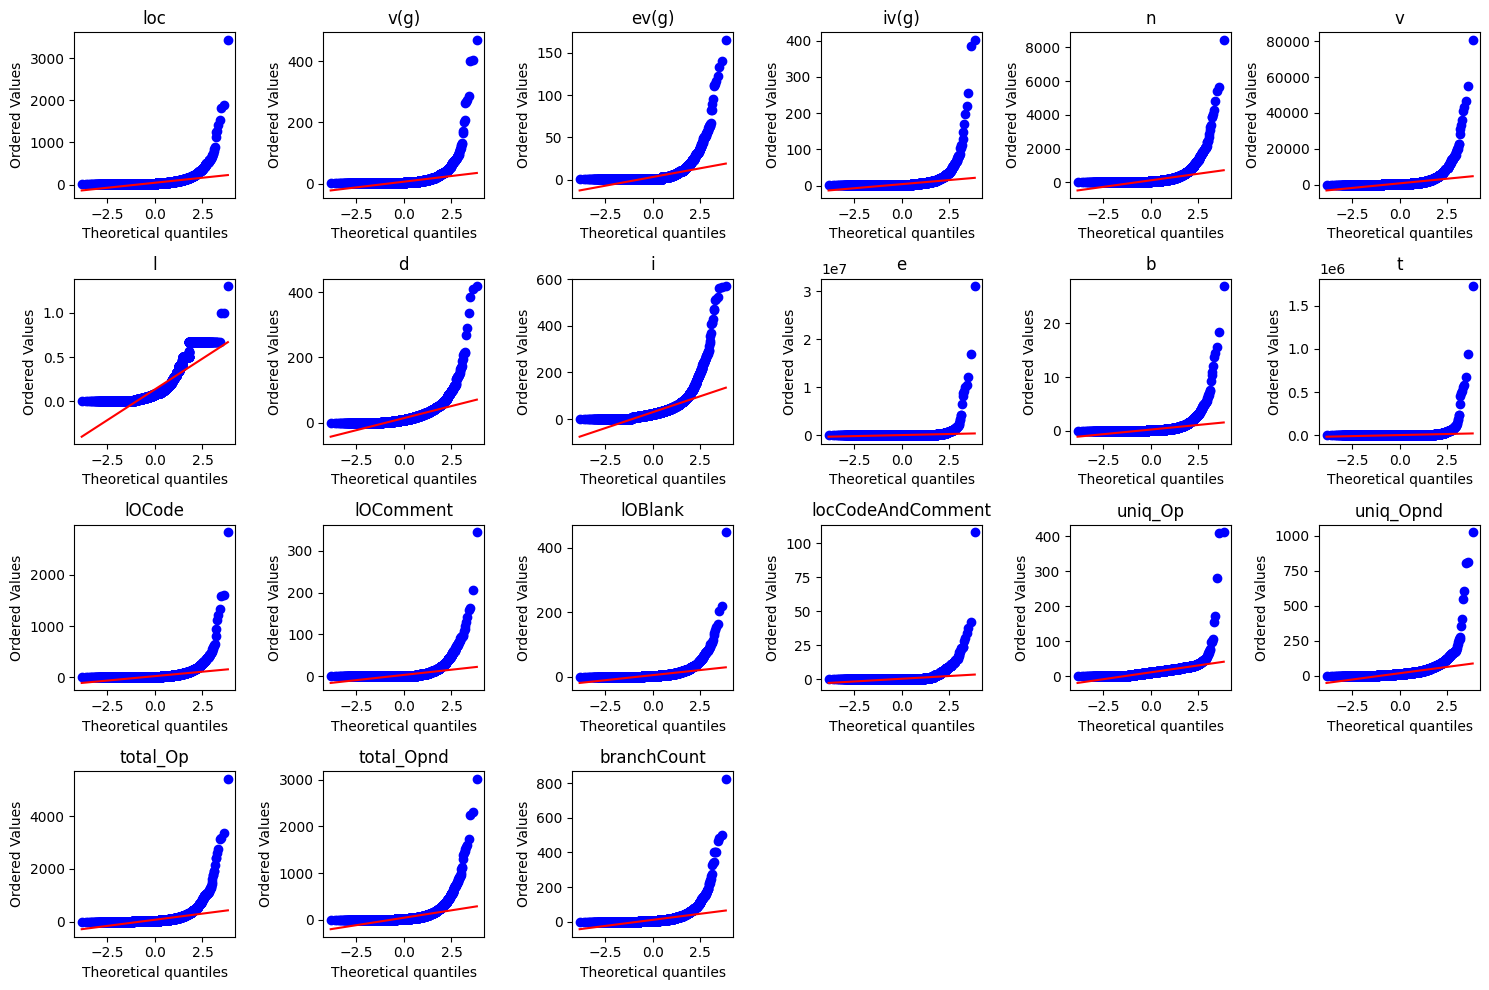

In [ ]:
numeric_columns = SDDataset.select_dtypes(include=[np.number]).columns
if 'defects' in numeric_columns:
    numeric_columns = numeric_columns.drop('defects')

# Plot Q-Q plots for each numeric variable
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns):
    plt.subplot(4, 6, i + 1)
    stats.probplot(SDDataset[col], dist="norm", plot=plt)
    plt.title(col)

plt.tight_layout()
plt.show()

Almost all the data are skewed. So we will transform them.

## Data Transformations

In [ ]:
# Separate features and target
features = SDDataset.drop(columns=['defects'])
target = SDDataset['defects']
numeric_features = features.select_dtypes(include=np.number)

# Apply log transformation
constant = 1
transformed_features = np.log1p(numeric_features) + constant

transformed_df = pd.concat([transformed_features, features.select_dtypes(exclude=np.number), target], axis=1)

In [ ]:
transformed_df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.741937,1.875469,1.875469,1.875469,1.832909,1.832909,1.832909,1.832909,1.832909,1.832909,...,2.098612,2.098612,2.098612,2.098612,1.788457,1.788457,1.788457,1.788457,1.875469,False
1,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,...,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,True
2,5.290459,3.079442,1.693147,2.945910,6.293305,8.034502,1.048790,4.059176,5.040416,11.044557,...,4.951244,3.397895,3.197225,1.693147,3.890372,4.610918,5.727388,5.465908,3.639057,True
3,6.252273,2.386294,1.693147,2.386294,7.398595,9.377876,1.058269,3.893700,6.544670,12.214569,...,5.867534,4.401197,4.367296,2.098612,3.890372,5.912655,6.799093,6.605802,2.791759,True
4,4.637586,2.609438,1.693147,2.609438,5.844187,7.397130,1.058269,3.900872,4.579622,10.239734,...,4.367296,1.693147,2.945910,1.000000,3.484907,3.833213,5.343805,4.931826,3.079442,True


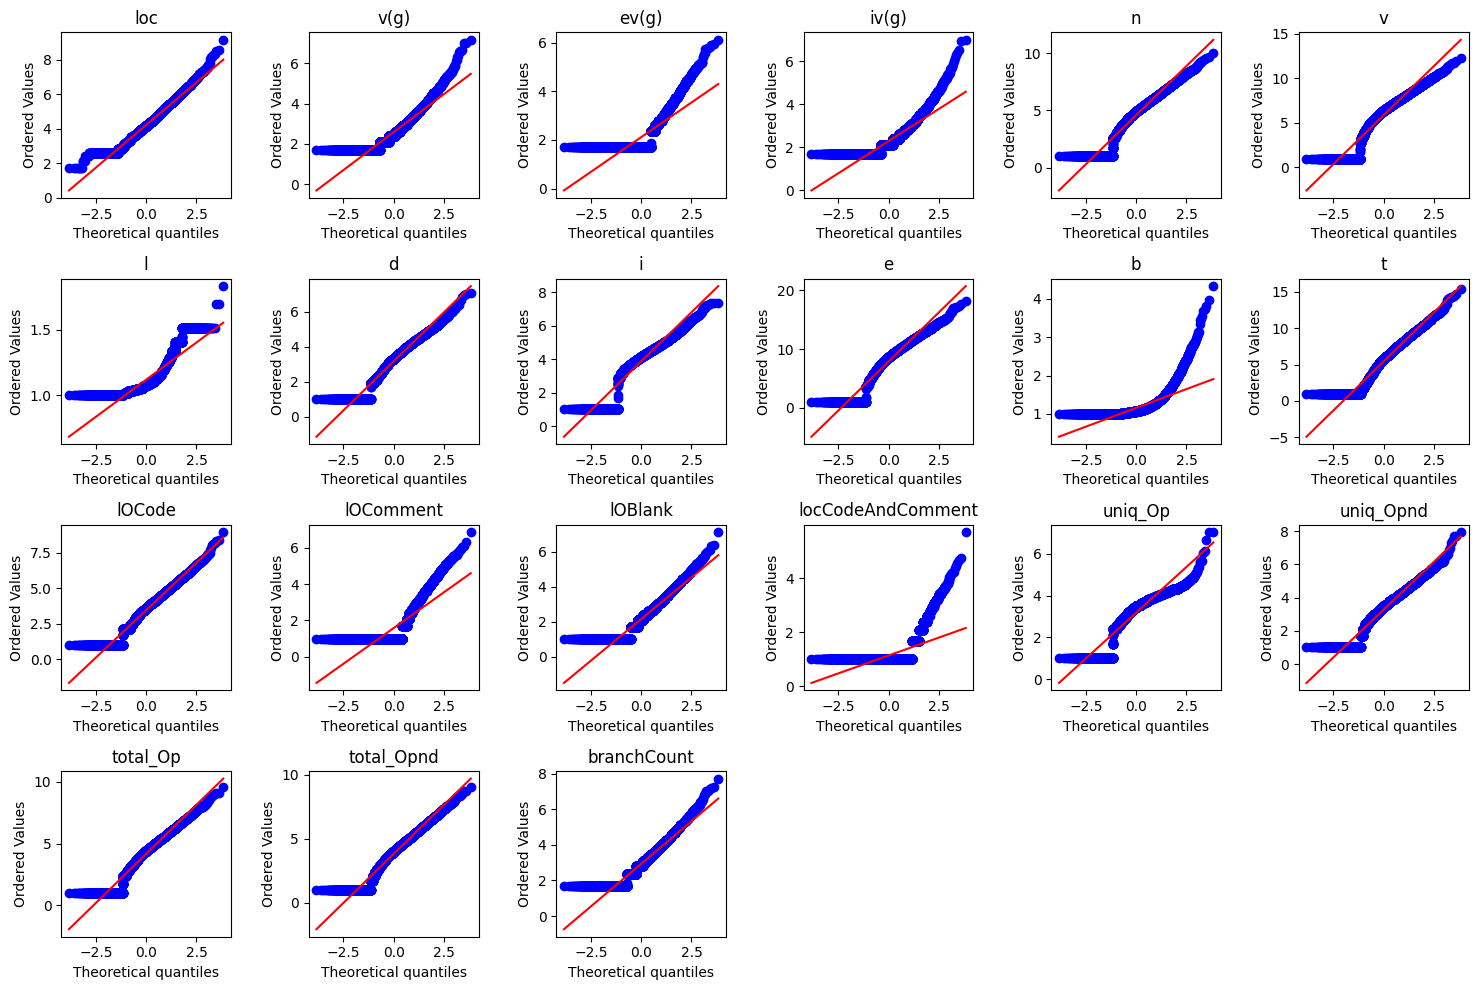

In [ ]:
numeric_columns = transformed_df.select_dtypes(include=[np.number]).columns
if 'defects' in numeric_columns:
    numeric_columns = numeric_columns.drop('defects')

# Plot Q-Q plots for each numeric variable
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns):
    plt.subplot(4, 6, i + 1)
    stats.probplot(transformed_df[col], dist="norm", plot=plt)
    plt.title(col)

plt.tight_layout()
plt.show()

## Encode Target Variable

In [ ]:
label_encoder = LabelEncoder()
transformed_df['defects'] = label_encoder.fit_transform(transformed_df['defects'])

In [ ]:
transformed_df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.741937,1.875469,1.875469,1.875469,1.832909,1.832909,1.832909,1.832909,1.832909,1.832909,...,2.098612,2.098612,2.098612,2.098612,1.788457,1.788457,1.788457,1.788457,1.875469,0
1,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,...,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1.693147,1
2,5.290459,3.079442,1.693147,2.945910,6.293305,8.034502,1.048790,4.059176,5.040416,11.044557,...,4.951244,3.397895,3.197225,1.693147,3.890372,4.610918,5.727388,5.465908,3.639057,1
3,6.252273,2.386294,1.693147,2.386294,7.398595,9.377876,1.058269,3.893700,6.544670,12.214569,...,5.867534,4.401197,4.367296,2.098612,3.890372,5.912655,6.799093,6.605802,2.791759,1
4,4.637586,2.609438,1.693147,2.609438,5.844187,7.397130,1.058269,3.900872,4.579622,10.239734,...,4.367296,1.693147,2.945910,1.000000,3.484907,3.833213,5.343805,4.931826,3.079442,1


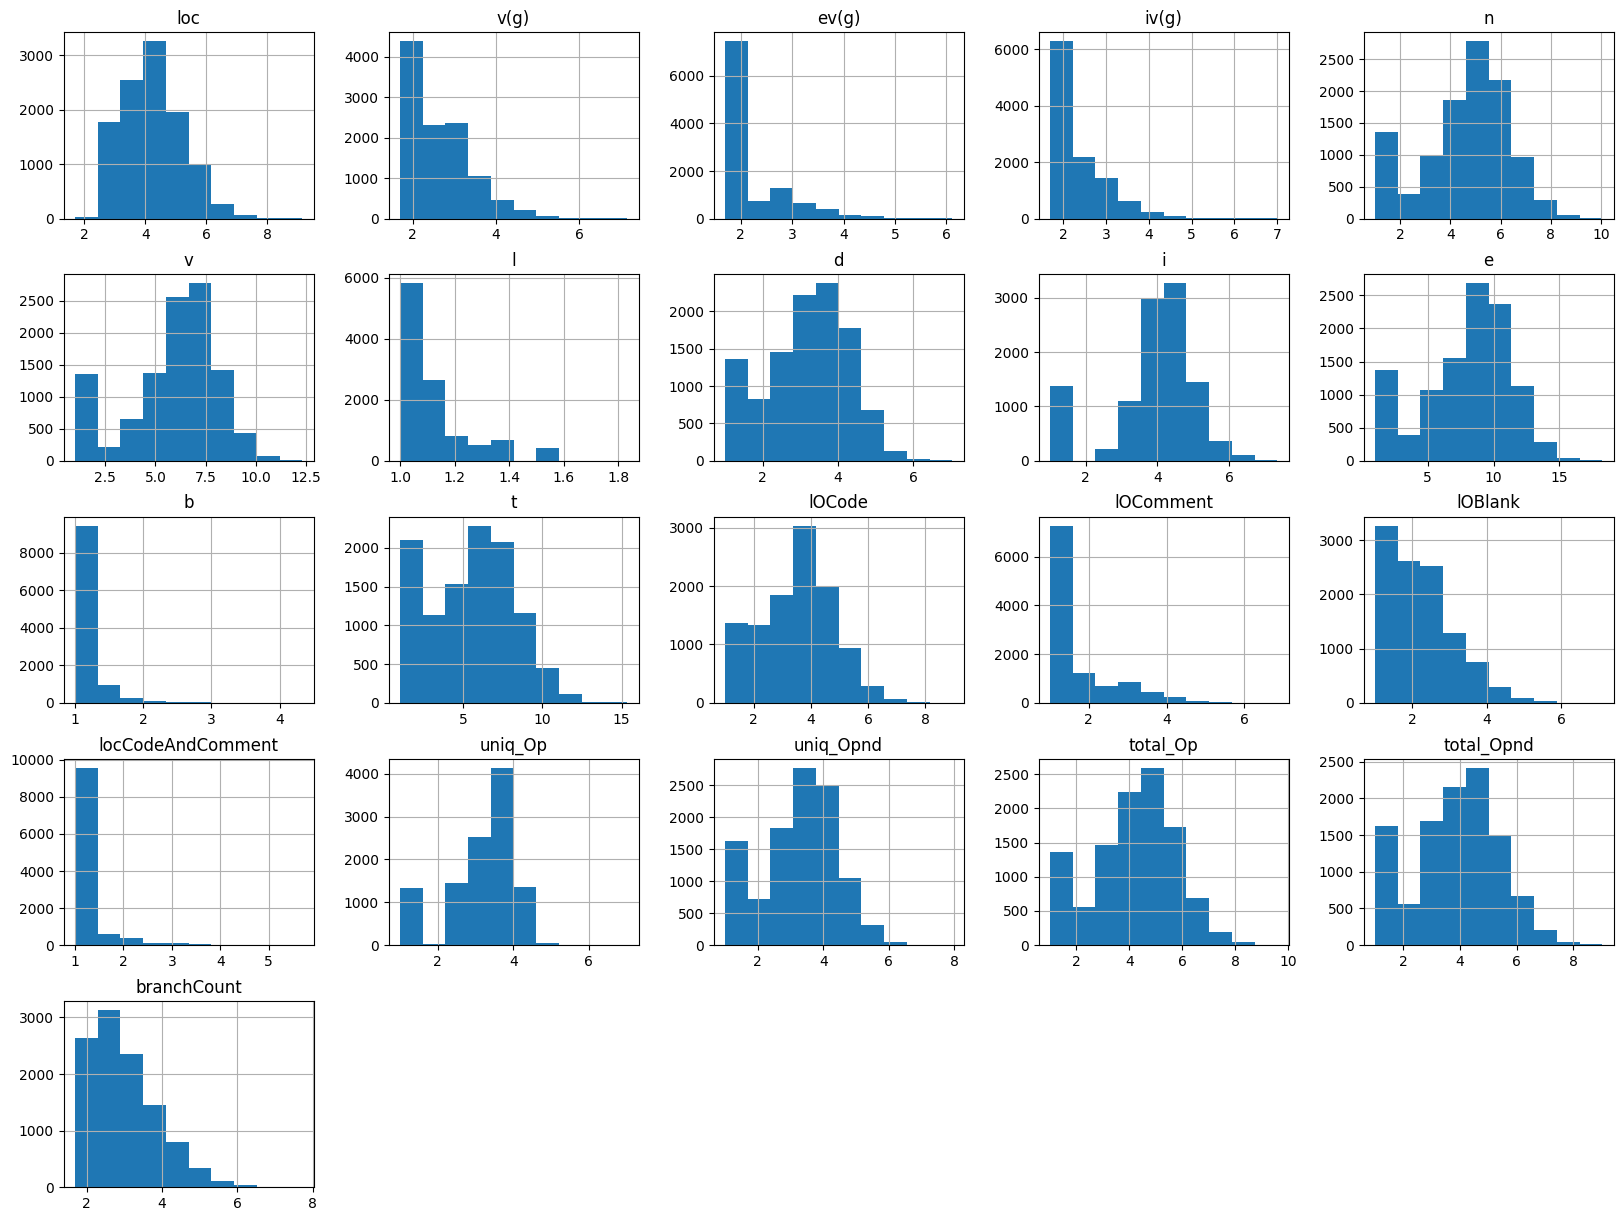

In [ ]:
transformed_df.iloc[:,:-1].hist(figsize=(20, 15))
plt.show()

## Feature Scaling

In [ ]:
# Separating features and target
target_column = 'defects'
features = transformed_df.drop(columns=[target_column])
target = transformed_df[target_column]

# Apply StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# Add the target column back to the scaled dataset
scaled_df[target_column] = target.reset_index(drop=True)

In [ ]:
scaled_df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,-2.465332,-0.890711,-0.332901,-0.641389,-1.556028,-1.746857,5.621878,-1.155394,-1.604653,-1.752228,...,-0.996983,0.537234,-0.055125,2.208835,-1.454599,-1.259911,-1.458094,-1.301221,-1.063828,0
1,-2.514194,-1.121073,-0.591528,-0.920200,-1.634833,-1.807271,4.522387,-1.277217,-1.715062,-1.792550,...,-1.295054,0.118261,-0.462430,1.273286,-1.554487,-1.340386,-1.516595,-1.362342,-1.247774,1
2,1.088442,0.630502,-0.591528,0.995556,0.958965,0.933862,-0.546694,0.785125,0.929203,0.905370,...,1.100082,1.879805,1.048473,1.273286,0.748258,1.123222,0.959590,1.057060,0.715469,1
3,2.051680,-0.245285,-0.591528,0.139778,1.582182,1.514553,-0.472126,0.640887,2.117528,1.242923,...,1.773679,2.916533,2.223855,2.208835,0.748258,2.222339,1.617394,1.788053,-0.139376,1
4,0.434603,0.036655,-0.591528,0.481015,0.705730,0.658349,-0.472126,0.647139,0.565187,0.673175,...,0.670803,0.118261,0.796018,-0.326046,0.323320,0.466570,0.724150,0.714563,0.150869,1


## Correlation Analysis

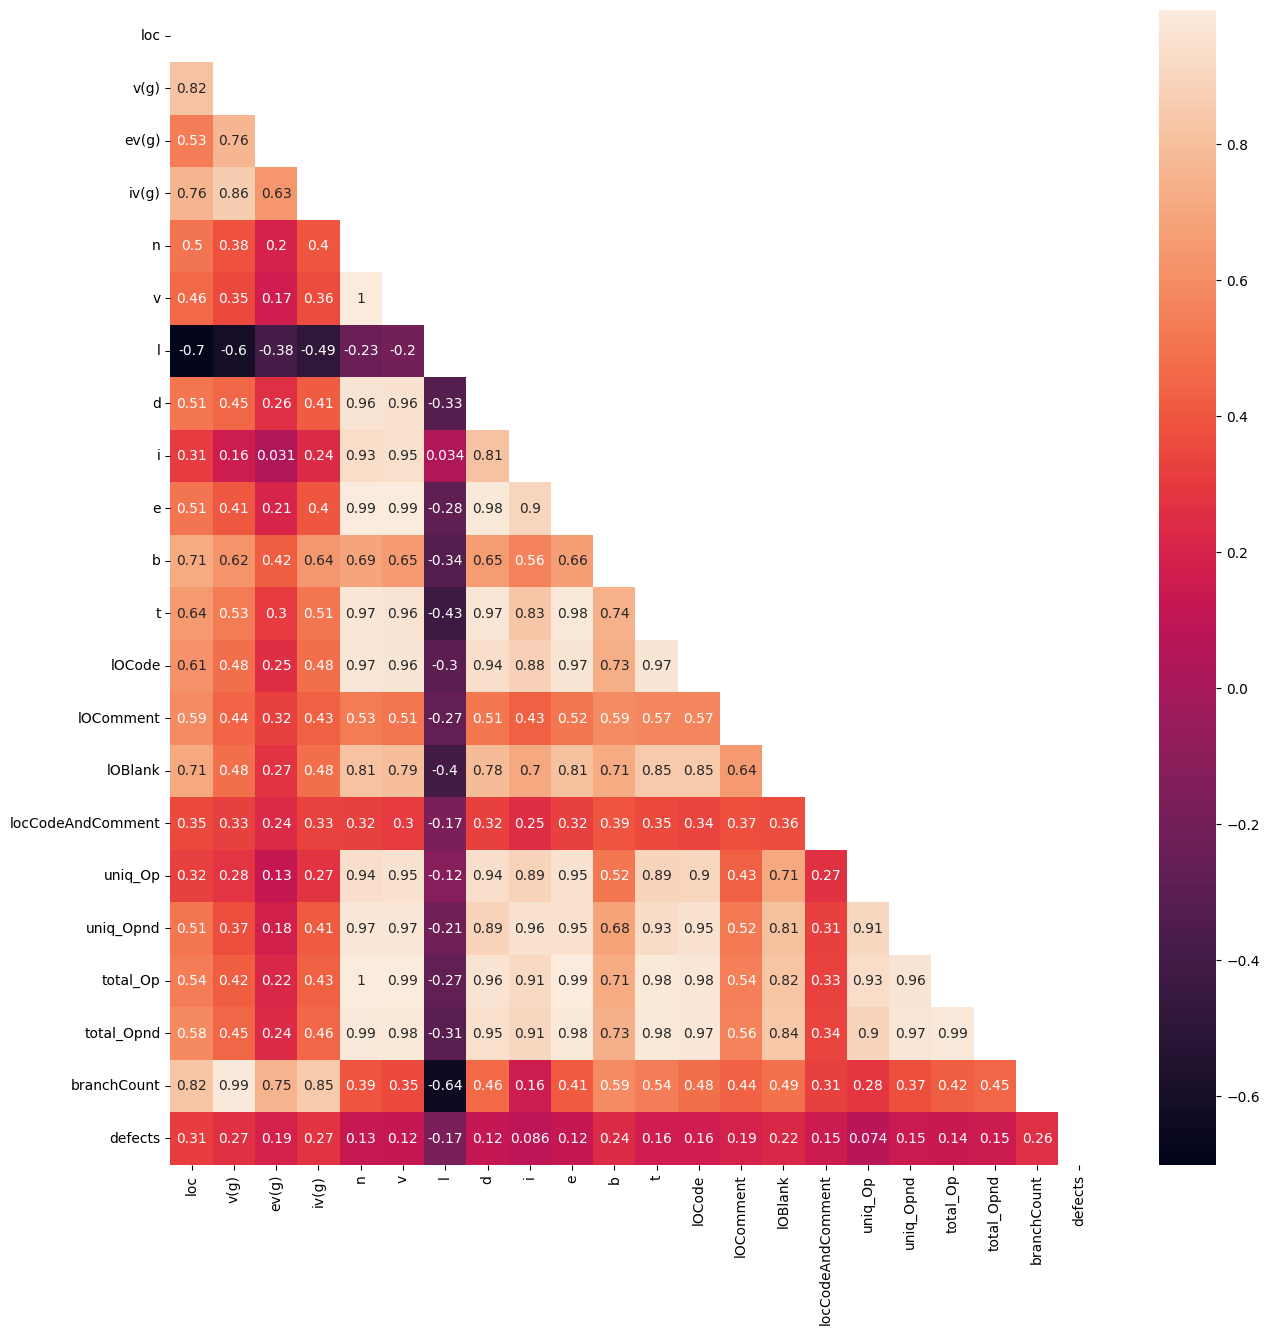

In [ ]:
plt.figure(figsize=(15, 15))
corr = scaled_df.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, mask=mask)
plt.show()

By analysing the correlation matrix, we can see that some features are highly correlated. It may cause multicollinearity issues. Features with a correlation coefficient with 1 will be removed.

v and n have a correlation of 1.
n and total_Op show a strong correlation of 1.

In [ ]:
# Drop highly correlated features
scaled_df = scaled_df.drop(['v', 'n'], axis=1)

# Model Development

In [ ]:
X = scaled_df.drop(columns=['defects'])
y = scaled_df['defects']

In [ ]:
X.shape, y.shape

((10880, 19), (10880,))

## Oversampling with SMOTE

As we previously saw, the dataset is highly imbalanced. So we will oversample the data set. Here I use Standard SMOTE since this dataset has only numerical data.

In [ ]:
# Apply Standard SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
X_resampled.shape, y_resampled.shape

((17554, 19), (17554,))

# Model Training and Testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Training and Testing the XGBoost Model

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 7025, number of negative: 7018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 14043, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500249 -> initscore=0.000997
[LightGBM] [Info] Start training from score 0.000997


In [ ]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Model Evaluation

Evaluation of XGBoost, LightGBM and Random Forest

XGBoost Performance Metrics:
Accuracy: 0.8763884933067502
F1 Score: 0.8704477611940298

Confusion Matrix:
 [[1619  140]
 [ 294 1458]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88      1759
           1       0.91      0.83      0.87      1752

    accuracy                           0.88      3511
   macro avg       0.88      0.88      0.88      3511
weighted avg       0.88      0.88      0.88      3511

ROC-AUC Score: 0.9391355871045453

LightGBM Performance Metrics:
Accuracy: 0.8598689831956707
F1 Score: 0.8531343283582089

Confusion Matrix:
 [[1590  169]
 [ 323 1429]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1759
           1       0.89      0.82      0.85      1752

    accuracy                           0.86      3511
   macro avg       0.86      0.86      0.86      3511
weighted avg       0.86      0.86      0.86    

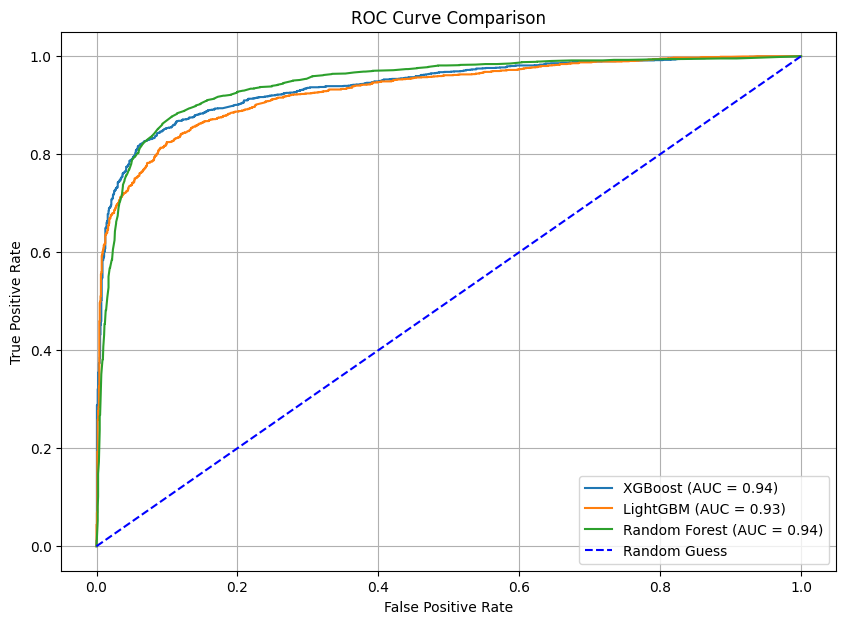

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Store model predictions and probabilities
models = {
    "XGBoost": (y_pred_xgb, y_proba_xgb),
    "LightGBM": (y_pred_lgb, y_proba_lgb),
    "Random Forest": (y_pred_rf, y_proba_rf)
}

# Evaluate each model and calculate performance metrics
for model_name, (y_pred, y_proba) in models.items():
    print(f"{model_name} Performance Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    auc_roc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC Score: {auc_roc}\n")

# Plot ROC curves for all models in one plot
plt.figure(figsize=(10, 7))
for model_name, (y_pred, y_proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_roc:.2f})")

# Add random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='blue', label='Random Guess')

# Configure plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Hyperparameter Tuning

Hyperparameter Tuning for XGBoost Model

In [ ]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

xgb_grid_search = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5,
                           verbose=2)

xgb_grid_search.fit(X_train, y_train)

print("Best Parameters:", xgb_grid_search.best_params_)
print("Best ROC-AUC Score:", xgb_grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   4.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   4.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   4.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   3.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

So the best parameters I found during hyperparameter tuning(For XGBoost Model) are:
learning_rate: 0.2
max_depth: 7
n_estimators: 300

In [ ]:
# Hyperparameter grid for LightGBM
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [20, 31, 40],
    'min_child_samples': [10, 20, 30]
}

lgbm_model = LGBMClassifier(random_state=42)

lgbm_grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)

lgbm_grid_search.fit(X_train, y_train)

print("Best Parameters:", lgbm_grid_search.best_params_)
print("Best ROC-AUC Score:", lgbm_grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Number of positive: 7025, number of negative: 7018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 14043, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500249 -> initscore=0.000997
[LightGBM] [Info] Start training from score 0.000997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

So the best parameters I found during hyperparameter tuning(For LightGBM) are:
learning_rate: 0.1
max_depth: 7
min_child_samples: 10
n_estimators: 300
num_leaves: 40

In [ ]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", rf_grid_search.best_params_)
print("Best ROC-AUC Score:", rf_grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best ROC-AUC Score: 0.9350454721574565


## Ensemble Approach

In [ ]:
# Use best parameters for each model
xgb_model = xgb.XGBClassifier(**xgb_grid_search.best_params_, random_state=42)
lgbm_model = LGBMClassifier(**lgbm_grid_search.best_params_, random_state=42)
rf_model = RandomForestClassifier(**rf_grid_search.best_params_, random_state=42)

# Define base models
estimators = [
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('rf', rf_model)
]

# Define stacking ensemble
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),  # Meta-model
    cv=5
)

stacking_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7025, number of negative: 7018
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 14043, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500249 -> initscore=0.000997
[LightGBM] [Info] Start training from score 0.000997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lear...
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=42, ...)),
                               ('lgbm',
                                LGBMClassifier(max_depth=7,
                                               min_child_samples=10,
                                               n_estimators=300, num_leaves=40,
                                               random_state=42)),
                               ('rf',
                                RandomForestClassifier(n_estimators=300,
                                                       random_state=42))],
                   final_estimator=LogisticRegression())

## Evaluate Stacking Ensemble

In [ ]:
y_pred = stacking_model.predict(X_test)
y_proba = stacking_model.predict_proba(X_test)[:, 1]

Stacking Ensemble Performance Metrics:
Accuracy: 0.8923383651381372
F1 Score: 0.8903076030179919

Confusion Matrix:
 [[1599  160]
 [ 218 1534]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      1759
           1       0.91      0.88      0.89      1752

    accuracy                           0.89      3511
   macro avg       0.89      0.89      0.89      3511
weighted avg       0.89      0.89      0.89      3511

ROC-AUC Score: 0.9546463263944593


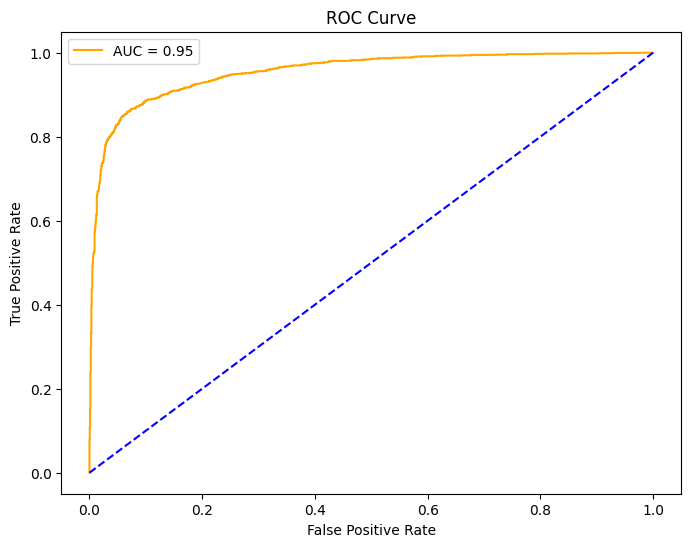

In [ ]:
# Evaluate Stacking Ensemble
print("Stacking Ensemble Performance Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC Score
auc_roc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {auc_roc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()